In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
import warnings
import logging


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('tensorflow').disabled = True


logging.getLogger('tensorflow').propagate = False
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.ERROR)

image_dir = '/kaggle/input/poverty-dataset/Dataset2'
image_size = (128, 128)

def load_images(image_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping.")
                continue
            img = cv2.resize(img, image_size)
            images.append(img)
            labels.append(0 if '_p' in filename else 1)
    return np.array(images), np.array(labels)

images, labels = load_images(image_dir)
images = images / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

def build_model(base_model, input_shape=(128, 128, 3), num_classes=1):
    base_model.trainable = False
    model = models.Sequential([
        layers.Input(shape=input_shape),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 189ms/step - accuracy: 0.6005 - loss: 0.8328 - val_accuracy: 0.6515 - val_loss: 1.4443
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7177 - loss: 0.7040 - val_accuracy: 0.6547 - val_loss: 2.8555
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.7080 - loss: 0.9575 - val_accuracy: 0.7296 - val_loss: 1.3708
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.7211 - loss: 0.9718 - val_accuracy: 0.6091 - val_loss: 1.8579
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7374 - loss: 0.5613 - val_accuracy: 0.7199 - val_loss: 1.4606
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.7190 - loss: 0.6318 - val_accuracy: 0.7687 - val_loss: 0.8643
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7368 - loss: 0.6404 - val_accuracy: 0.7687 - val_loss: 0.8511
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.7466 - loss: 0.7004 - val_acc

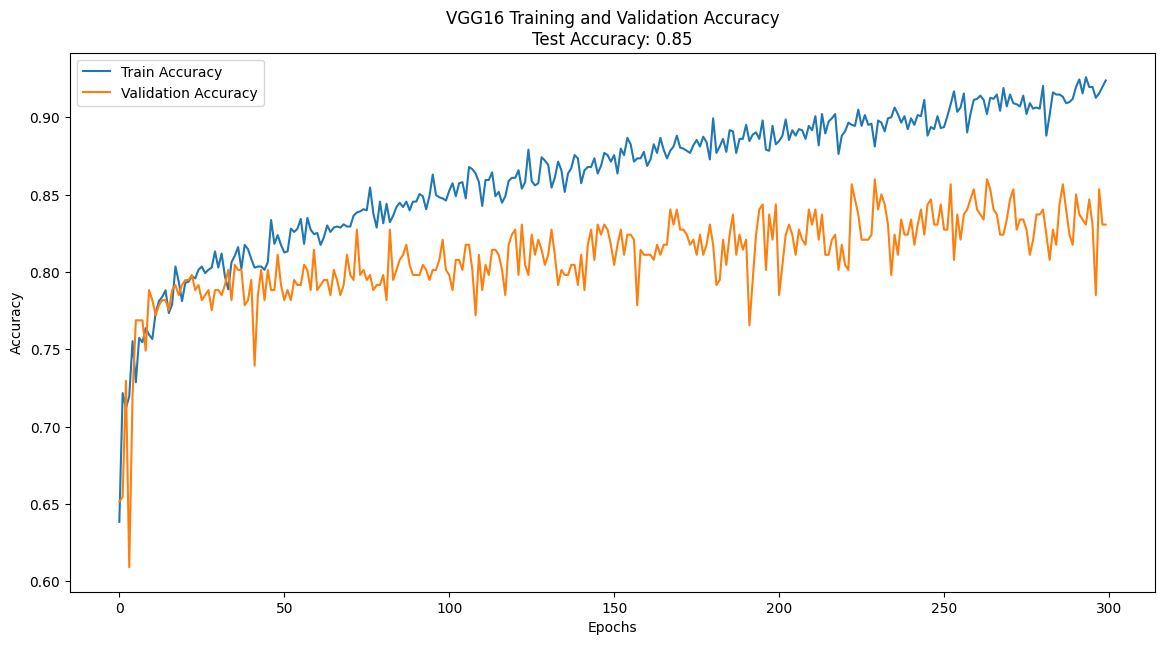

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


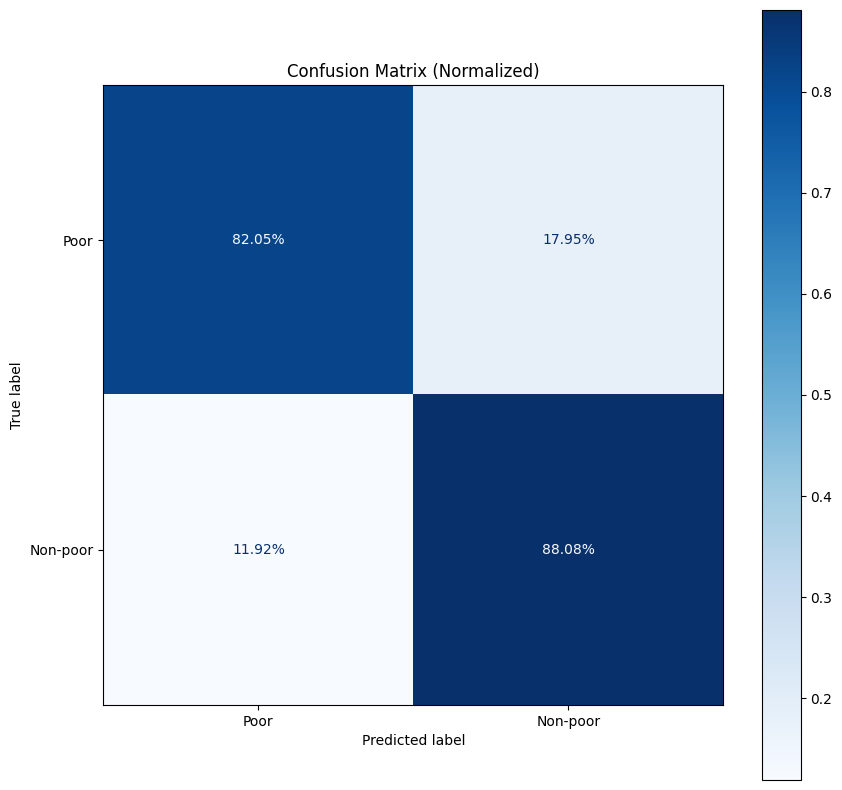

In [4]:
checkpoint_callback_vgg16 = ModelCheckpoint('best_model_VGG16.keras', monitor='val_loss', save_best_only=True)

vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_vgg16 = build_model(vgg16_base)

history_vgg16 = model_vgg16.fit(datagen.flow(X_train, y_train, batch_size=32),
                                validation_data=(X_val, y_val),
                                epochs=300,
                                callbacks=[early_stopping_callback, checkpoint_callback_vgg16, tensorboard_callback])

test_loss_vgg16, test_accuracy_vgg16 = model_vgg16.evaluate(X_test, y_test)
val_accuracy_vgg16 = max(history_vgg16.history['val_accuracy'])
val_loss_vgg16 = min(history_vgg16.history['val_loss'])

print(f'VGG16 Test accuracy: {test_accuracy_vgg16:.2f}')
print(f'VGG16 Validation accuracy: {val_accuracy_vgg16:.2f}')
print(f'VGG16 Validation loss: {val_loss_vgg16:.2f}')


model_vgg16.save('VGG16_poverty_classification_model_final.keras')


plt.figure(figsize=(14, 7))
plt.plot(history_vgg16.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'VGG16 Training and Validation Accuracy\nTest Accuracy: {test_accuracy_vgg16:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_vgg16 = (model_vgg16.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred_vgg16)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Poor', 'Non-poor'])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2%")
plt.title('Confusion Matrix (Normalized)')
plt.show()

Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 405ms/step - accuracy: 0.5066 - loss: 0.7079 - val_accuracy: 0.4821 - val_loss: 0.7064
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.5486 - loss: 0.6866 - val_accuracy: 0.6580 - val_loss: 0.6544
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.5981 - loss: 0.6639 - val_accuracy: 0.5440 - val_loss: 0.6750
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - accuracy: 0.5780 - loss: 0.6659 - val_accuracy: 0.6450 - val_loss: 0.6419
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 0.6422 - loss: 0.6471 - val_accuracy: 0.6938 - val_loss: 0.6245
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.6017 - loss: 0.6473 - val_accuracy: 0.6450 - val_loss: 0.6474
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.6682 - loss: 0.6248 - val_accuracy: 0.7003 - val_loss: 0.6188
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.6461 - loss: 0.6176 - 

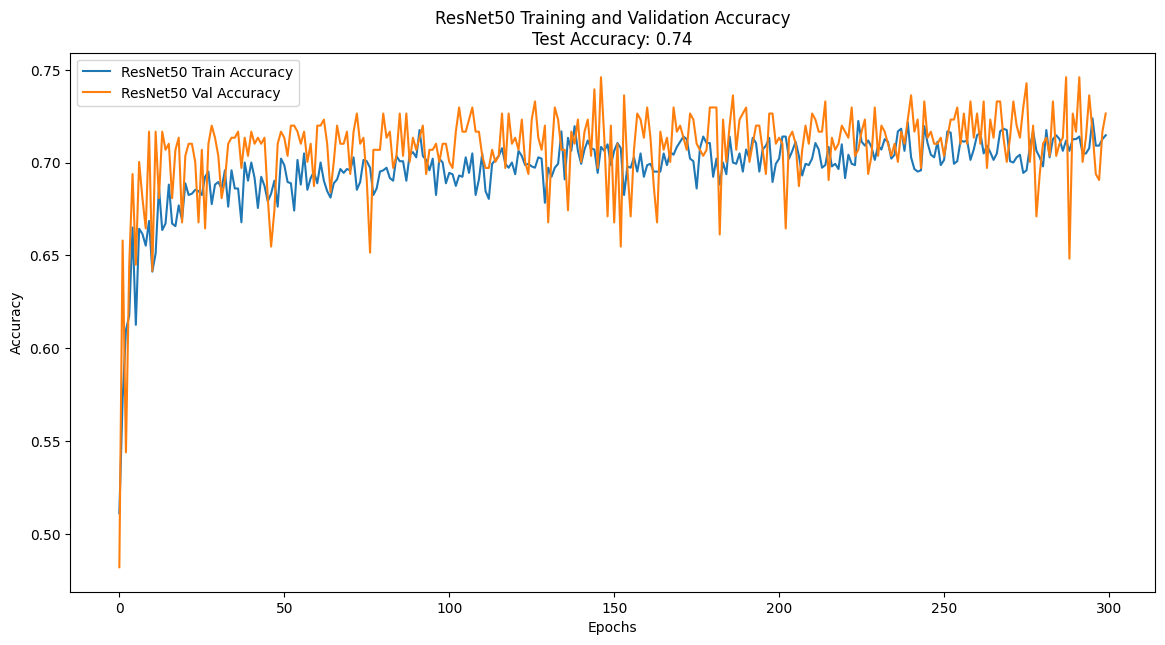

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 403ms/step


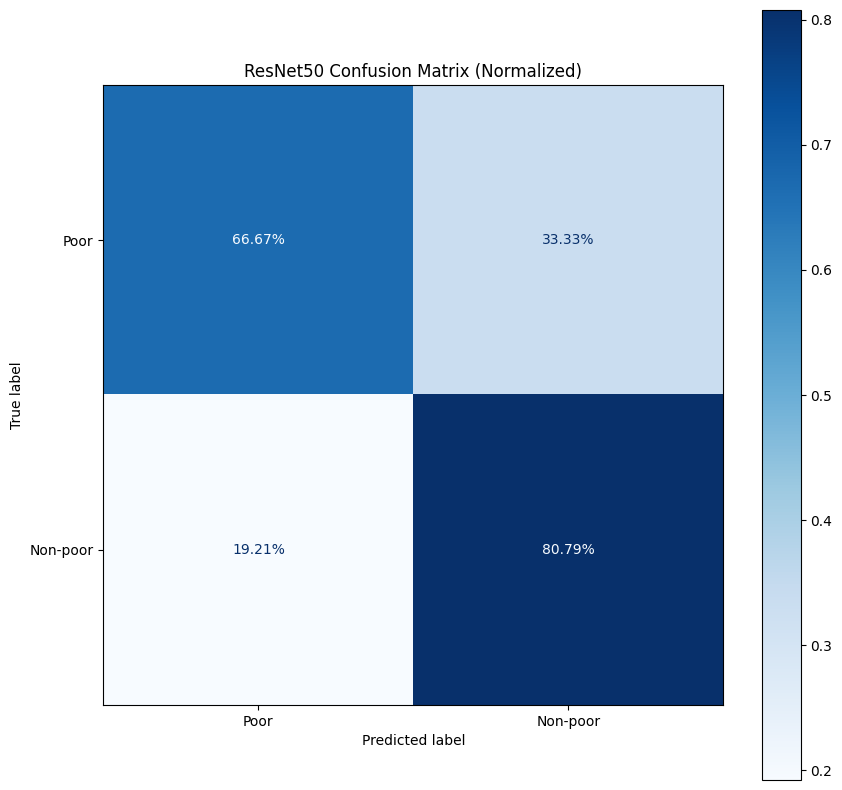

In [5]:
import warnings
warnings.filterwarnings('ignore', message='Fallback to op-by-op mode because memset node breaks graph update')

checkpoint_callback_resnet50 = ModelCheckpoint('best_model_ResNet50.keras', monitor='val_loss', save_best_only=True)

resnet50_base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_resnet50 = build_model(resnet50_base)

history_resnet50 = model_resnet50.fit(datagen.flow(X_train, y_train, batch_size=32),
                                      validation_data=(X_val, y_val),
                                      epochs=300,
                                      callbacks=[early_stopping_callback, checkpoint_callback_resnet50, tensorboard_callback])


test_loss_resnet50, test_accuracy_resnet50 = model_resnet50.evaluate(X_test, y_test)
val_accuracy_resnet50 = max(history_resnet50.history['val_accuracy'])
val_loss_resnet50 = min(history_resnet50.history['val_loss'])

print(f'ResNet50 Test accuracy: {test_accuracy_resnet50:.2f}')
print(f'ResNet50 Validation accuracy: {val_accuracy_resnet50:.2f}')
print(f'ResNet50 Validation loss: {val_loss_resnet50:.2f}')


model_resnet50.save('ResNet50_poverty_classification_model_final.keras')


plt.figure(figsize=(14, 7))
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Val Accuracy')
plt.title(f'ResNet50 Training and Validation Accuracy\nTest Accuracy: {test_accuracy_resnet50:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_resnet50 = (model_resnet50.predict(X_test) > 0.5).astype("int32")
cm_resnet50 = confusion_matrix(y_test, y_pred_resnet50)


cm_resnet50_normalized = cm_resnet50.astype('float') / cm_resnet50.sum(axis=1)[:, np.newaxis]


disp_resnet50 = ConfusionMatrixDisplay(confusion_matrix=cm_resnet50_normalized, display_labels=['Poor', 'Non-poor'])
fig, ax = plt.subplots(figsize=(10, 10))
disp_resnet50.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2%")
plt.title('ResNet50 Confusion Matrix (Normalized)')
plt.show()

Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - accuracy: 0.7287 - loss: 0.5593 - val_accuracy: 0.8469 - val_loss: 0.3466
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.8502 - loss: 0.3407 - val_accuracy: 0.8697 - val_loss: 0.2925
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.8805 - loss: 0.2869 - val_accuracy: 0.8762 - val_loss: 0.2813
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.8938 - loss: 0.2454 - val_accuracy: 0.8632 - val_loss: 0.3412
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.8972 - loss: 0.2615 - val_accuracy: 0.8795 - val_loss: 0.2611
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.9143 - loss: 0.2190 - val_accuracy: 0.8730 - val_loss: 0.2648
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.8922 - loss: 0.2642 - val_accuracy: 0.8827 - val_loss: 0.2587
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9043 - loss: 0.2184 - val_acc

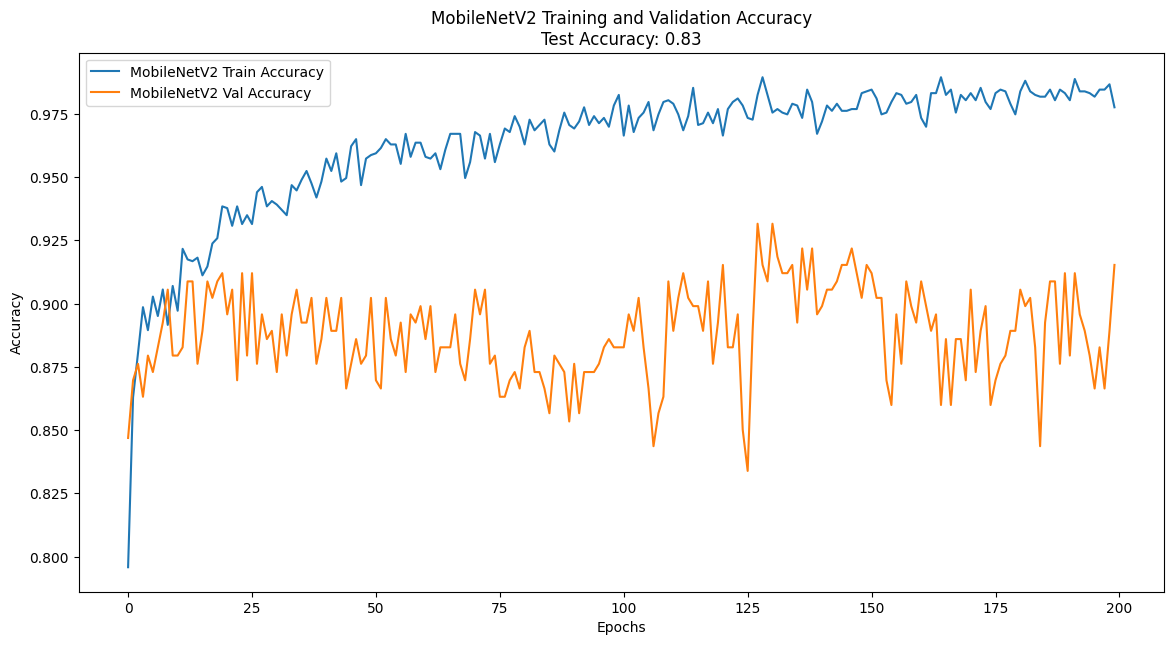

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 339ms/step


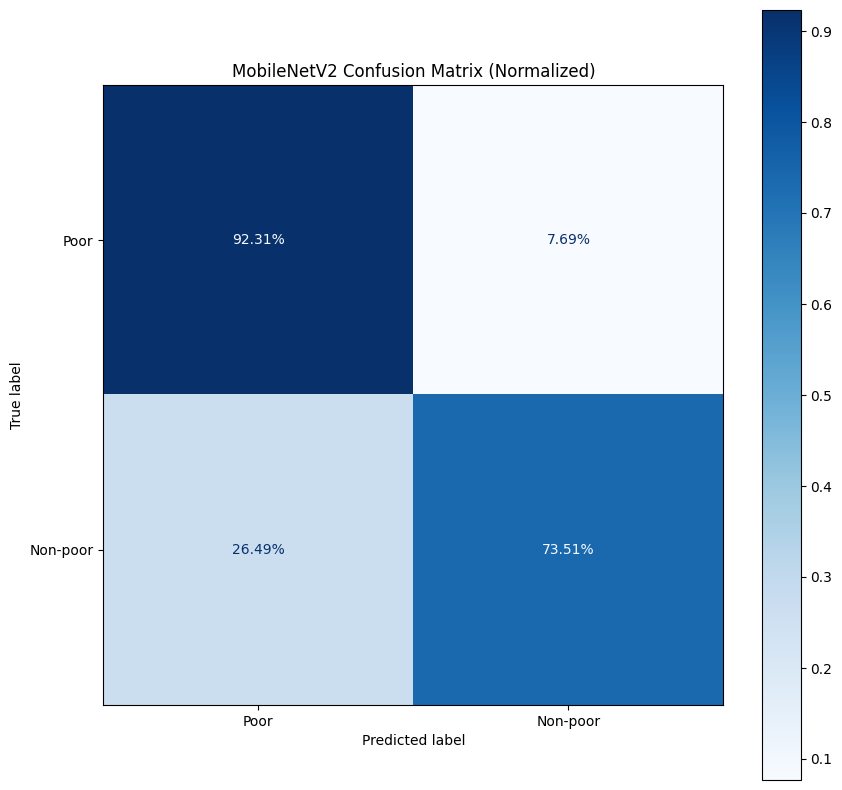

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


checkpoint_callback_mobilenetv2 = ModelCheckpoint('best_model_MobileNetV2.keras', monitor='val_loss', save_best_only=True)


mobilenetv2_base = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_mobilenetv2 = build_model(mobilenetv2_base)


history_mobilenetv2 = model_mobilenetv2.fit(datagen.flow(X_train, y_train, batch_size=32),
                                            validation_data=(X_val, y_val),
                                            epochs=300,
                                            callbacks=[early_stopping_callback, checkpoint_callback_mobilenetv2, tensorboard_callback])


test_loss_mobilenetv2, test_accuracy_mobilenetv2 = model_mobilenetv2.evaluate(X_test, y_test)
val_accuracy_mobilenetv2 = max(history_mobilenetv2.history['val_accuracy'])
val_loss_mobilenetv2 = min(history_mobilenetv2.history['val_loss'])

print(f'MobileNetV2 Test accuracy: {test_accuracy_mobilenetv2:.2f}')
print(f'MobileNetV2 Validation accuracy: {val_accuracy_mobilenetv2:.2f}')
print(f'MobileNetV2 Validation loss: {val_loss_mobilenetv2:.2f}')


model_mobilenetv2.save('MobileNetV2_poverty_classification_model_final.keras')


plt.figure(figsize=(14, 7))
plt.plot(history_mobilenetv2.history['accuracy'], label='MobileNetV2 Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='MobileNetV2 Val Accuracy')
plt.title(f'MobileNetV2 Training and Validation Accuracy\nTest Accuracy: {test_accuracy_mobilenetv2:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


y_pred_mobilenetv2 = (model_mobilenetv2.predict(X_test) > 0.5).astype("int32")
cm_mobilenetv2 = confusion_matrix(y_test, y_pred_mobilenetv2)


cm_mobilenetv2_normalized = cm_mobilenetv2.astype('float') / cm_mobilenetv2.sum(axis=1)[:, np.newaxis]


disp_mobilenetv2 = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenetv2_normalized, display_labels=['Poor', 'Non-poor'])
fig, ax = plt.subplots(figsize=(10, 10))
disp_mobilenetv2.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2%")
plt.title('MobileNetV2 Confusion Matrix (Normalized)')
plt.show()


Epoch 1/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.4963 - loss: 0.7596 - val_accuracy: 0.5928 - val_loss: 2.9174
Epoch 2/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.5494 - loss: 2.8085 - val_accuracy: 0.7036 - val_loss: 3.0803
Epoch 3/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.6580 - loss: 0.6196 - val_accuracy: 0.7134 - val_loss: 1.2129
Epoch 4/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6580 - loss: 0.7895 - val_accuracy: 0.7329 - val_loss: 0.8934
Epoch 5/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6968 - loss: 0.6092 - val_accuracy: 0.6156 - val_loss: 0.8565
Epoch 6/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6726 - loss: 0.6150 - val_accuracy: 0.7231 - val_loss: 0.7607
Epoch 7/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.7324 - loss: 0.5588 - val_accuracy: 0.5928 - val_loss: 0.9380
Epoch 8/300
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7297 - loss: 0.5387 - val_accuracy: 

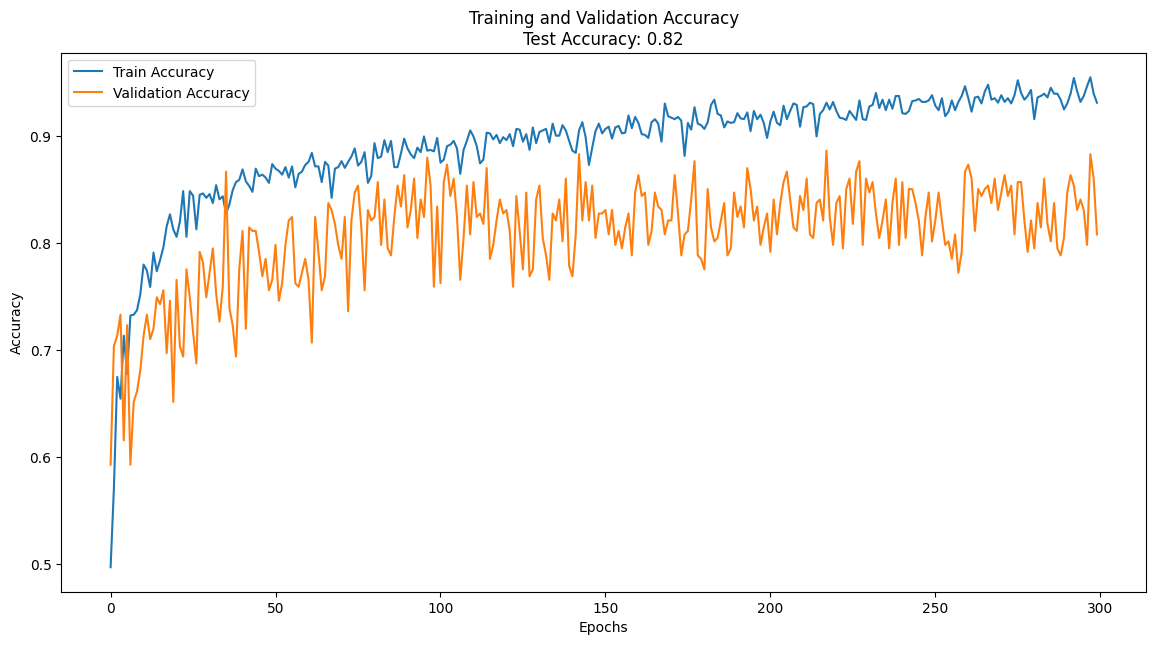

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


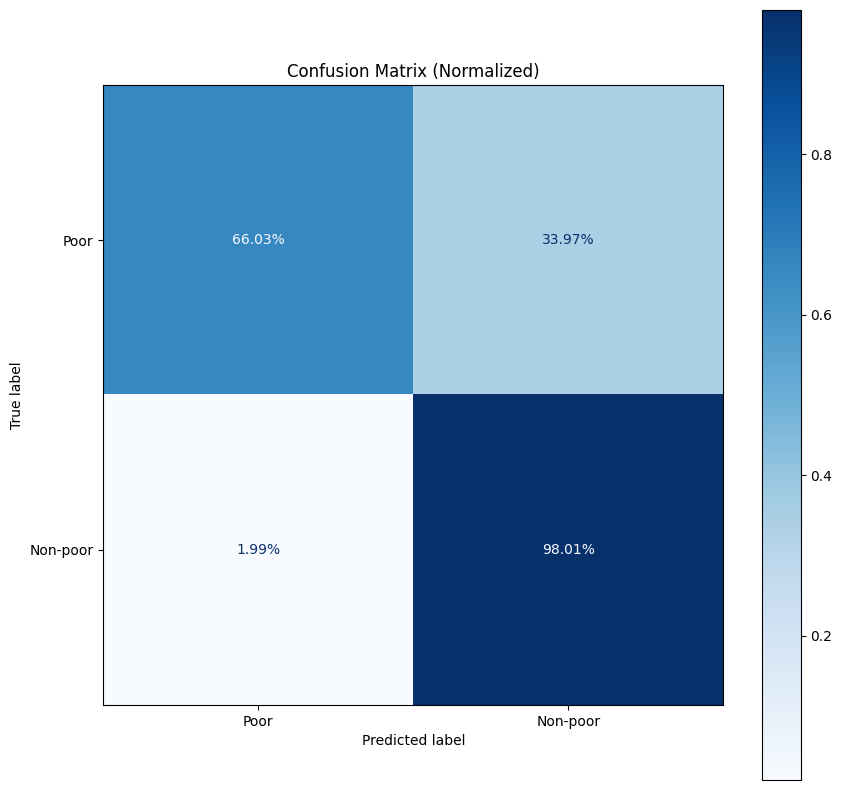

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, models

image_dir = '/kaggle/input/poverty-dataset/Dataset2'
image_size = (128, 128)  

def load_images(image_dir):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(image_dir, filename)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image {img_path}. Skipping.")
                continue
            img = cv2.resize(img, image_size)
            images.append(img)
            if '_p' in filename:
                labels.append(0)  # 0 for poor countries
            else:
                labels.append(1)  # 1 for rich countries
    return np.array(images), np.array(labels)

images, labels = load_images(image_dir)
images = images / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',  
              metrics=['accuracy'])

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=300)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}')


final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f'Final Validation Accuracy: {final_val_accuracy}')
print(f'Final Validation Loss: {final_val_loss}')

model.save('poverty_classification_model.h5')

plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy\nTest Accuracy: {test_accuracy:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Poor', 'Non-poor'])
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2%")
plt.title('Confusion Matrix (Normalized)')
plt.show()
